## 1. Import Libraries

**Author:** Alva Rani James, PhD, **Year:** 2023

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

ModuleNotFoundError: No module named 'sklearn'

- **Tip:** Intall the packages, which are not avaliable by using the below command line trick in the juypter note by using "!" mark

In [4]:
#!pip install imblearn

# Logistic regression 

Logistic Regression is a type of classification algorithm in Machine Learning that is utilized to estimate the probability of a categorical dependent variable. This approach is typically applied to binary variables, where the data is represented as either 1 (for success, yes, etc.) or 0 (for failure, no, etc.). Essentially, the logistic regression model predicts the likelihood of Y being 1 based on the values of X.

## Logistic regression assumptions

To perform binary logistic regression:

- It is essential that the dependent variable is binary and that the level 1 of the dependent variable signifies the intended outcome
- It is imperative to include only the relevant variables and ensure that the independent variables are not highly correlated, that is, multicollinearity should be minimized
- Additionally, the independent variables should exhibit a linear relationship with the log odds, and a substantial sample size is required for logistic regression to be effective 

Given these assumptions, we can now examine our dataset

# Download the data 

In [4]:
! wget https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv

--2023-03-07 18:17:20--  https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4882918 (4.7M) [text/plain]
Saving to: ‘banking.csv’

100%[======================================>] 4,882,918   13.7MB/s   in 0.3s   

2023-03-07 18:17:21 (13.7 MB/s) - ‘banking.csv’ saved [4882918/4882918]



# 2. Export the data

The data originates from the UCI Machine Learning repository and pertains to phone-based direct marketing campaigns carried out by a Portuguese banking institution. 
- The objective of the classification exercise is to anticipate whether the customer will agree to subscribe (1/0) to a term deposit, as denoted by the variable y

In [7]:
df =pd.read_csv("/home/ctg/Share/L_posts/data/banking.csv",header=0)
df =df.dropna()
print("The shape of the data: ",df.shape)
print("columns:",list(df.columns))

The shape of the data:  (41188, 21)
columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


## Preprocessing or Data cleaning

## 1.1 Input variables

In [8]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

## 1.2 Check the categorical columns and reduce the catogires for a better modelling

In [9]:
cat_cols= list(df.select_dtypes(include=['object']).columns)
cat_df=[]
for cat_col in cat_cols:
    df_cate = cat_col,df[cat_col].drop_duplicates()
    cat_df.append(df_cate)
cat_df[0]

('job',
 0        blue-collar
 1         technician
 2         management
 3           services
 4            retired
 8             admin.
 10         housemaid
 19        unemployed
 25      entrepreneur
 68     self-employed
 70           unknown
 103          student
 Name: job, dtype: object)

In [10]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

The above datafarme gives you the list of values within each categorical columns. From the columns, the education column has got many categories, hence, we need to reduce those categorires. 

The following categories are their in education column:


In [11]:
cat_df[2]

('education',
 0                  basic.4y
 1                   unknown
 2         university.degree
 3               high.school
 7                  basic.9y
 23      professional.course
 28                 basic.6y
 3059             illiterate
 Name: education, dtype: object)

We could group all the categories with basic* into one group and call them "basic"

In [12]:
df['education']=np.where(df['education'] =='basic.9y', 'Basic', df['education'])
df['education']=np.where(df['education'] =='basic.6y', 'Basic', df['education'])
df['education']=np.where(df['education'] =='basic.4y', 'Basic', df['education'])

## 1.2.1 After grouping

In [13]:
df['education'].drop_duplicates()

0                     Basic
1                   unknown
2         university.degree
3               high.school
23      professional.course
3059             illiterate
Name: education, dtype: object

# 2. Data Exploration

In [14]:
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

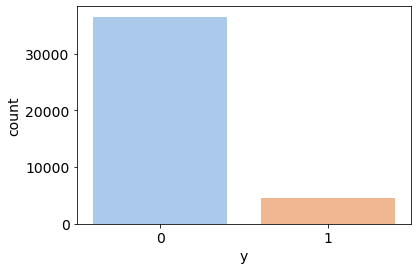

In [15]:
sns.countplot(x="y",data=df,palette='pastel')
plt.show()

## 2.1 Get the percentage of subscriptions

In [16]:
count_no_sub = len(df[df['y']==0])
count_sub = len(df[df['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


The distribution of instances across our classes is imbalanced, with a ratio of 89:11 between no-subscription and subscription cases. 
   - Prior to taking steps to rectify this issue, we must conduct further investigation.

###  2.1.1 Mean on neumerical columns

In [17]:
df.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


### 2.1.1 Observations

- Customers who purchased the term deposit have a higher average age in comparison to those who did not
- Additionally, the pdays (i.e., the number of days since the last time the customer was contacted) is lower for the customers who agreed to the term deposit offer, which is expected since customers are more likely to remember the previous call and increase the likelihood of a successful sale 
- Interestingly, the number of contacts or calls made during the current campaign is lower for customers who subscribed to the term deposit, which is somewhat unexpected

### 2.1.2 Mean on categorical columns to get more sense of our data

In [18]:
df.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [19]:
df.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [20]:
df.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


# 3. Visualizations

## 3.1.1 on job title

- generate functions for visualizations since we will be using teh same line of script multiple times for many columns

In [21]:
def visuals(df, title,xla):
    """get the bar plots for the given columns"""
    pd.crosstab(df.job,df.y).plot(kind='bar')
    plt.title(title)
    plt.xlabel(xla)
    plt.ylabel("Frequency of Purchase")
def visuals_2(df, catcol,title,xla,yla):
    table=pd.crosstab(df[catcol],df.y)
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title(title)
    plt.xlabel(xla)
    plt.ylabel(yla)

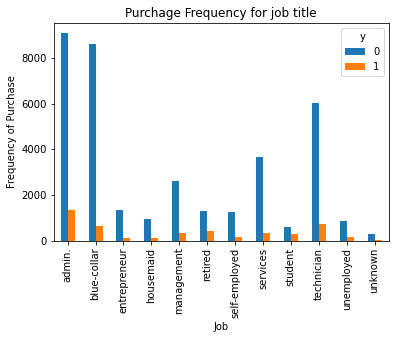

In [22]:
%matplotlib inline
visuals(df, "Purchage Frequency for job title","Job")

- The frequency of purchase depends on job title. Hence, job title can be a good predictor of the outcome

### 3.1.2 on marital status

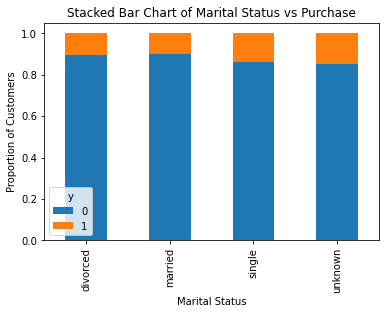

In [23]:
visuals_2(df, "marital",'Stacked Bar Chart of Marital Status vs Purchase','Marital Status','Proportion of Customers')

### 3.1.3 on eductaion status

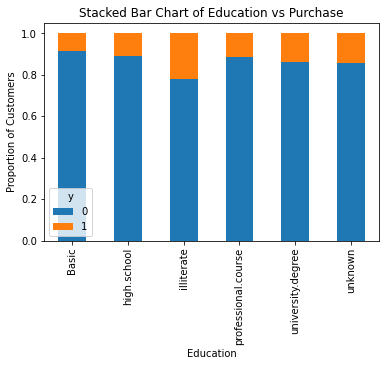

In [24]:
visuals_2(df, "education",'Stacked Bar Chart of Education vs Purchase','Education','Proportion of Customers')

- Education appears to be a good predictor of the outcome variable

### 3.1.3 Day of the week

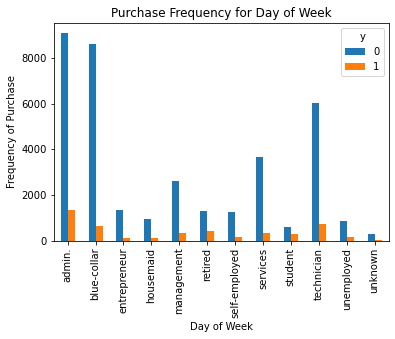

In [25]:
visuals(df, "Purchase Frequency for Day of Week","Day of Week")

- Day of week may appear to be not a good predictor of the outcome 



## 3.1.4 month

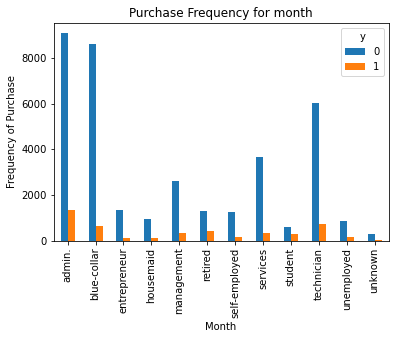

In [26]:
visuals(df, "Purchase Frequency for month","Month")

- Month might be a good predictor

### 3.1.5 Age

Text(0, 0.5, 'Frequency')

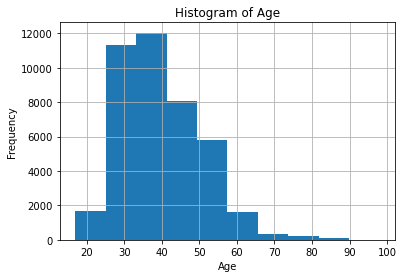

In [27]:
df.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

- most of the customers of the bank are in the age range of 30-40 years old

## 3.1.6 Poutcome

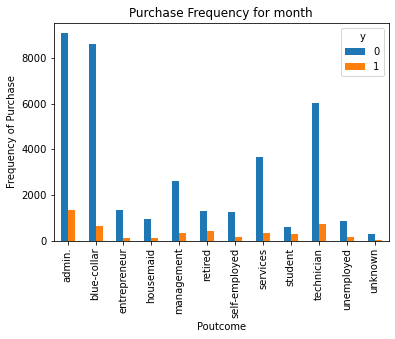

In [28]:
visuals(df, "Purchase Frequency for month","Poutcome")

- Poutcome seems to be a good predictor of the outcome variable.



## Convert the categorical variables into dummy binaries
 - We are gonna use the following categorical columns

In [29]:
data=df


In [30]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [31]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

#### Our final data columns will be:

In [32]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

## Over-sampling to overcome the sample imbalance between subscriptions and non-subscriptions

After constructing our training data, 
- I will apply the SMOTE algorithm (Synthetic Minority Oversampling Technique) to up-sample the no-subscription class
- Essentially, SMOTE functions by generating artificial samples of the underrepresented class instead of duplicating existing ones
- This is accomplished by selecting one of the k-nearest-neighbors at random and utilizing it to produce a comparable but randomly modified new instance
- Our implementation of SMOTE will take place in Python.

In [35]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


#### The data after performing SMOTE  for balancing 

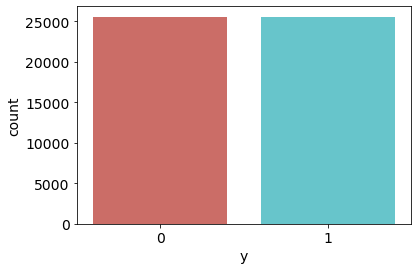

In [52]:
sns.countplot(data = os_data_y,x='y',palette='hls')
plt.show()

- We now have an ideally balanced dataset! 
- I applied oversampling to the training data
- This was done intentionally to prevent information from the test data being utilized in creating synthetic instances
- By only oversampling the training data, we ensure that no information is transferred from the test data to the model training process

## Construct the model with the best performing feature

## How can we choose the best performing feature?

- One way to do so is by using Recursive feature elimination method (Readmore https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

- The Recursive Feature Elimination (RFE) algorithm operates by constructing a model multiple times and selecting the best or worst performing feature in each iteration
- The chosen feature is then removed from the dataset, and the process is repeated with the remaining features
- This recursive process continues until all features in the dataset have been evaluated
- The primary objective of RFE is to choose features by iteratively considering smaller and smaller subsets of features







In [42]:
data_final_vars=data_final.columns.values.tolist()
y      =['y']
X      =[i for i in data_final_vars if i not in y]
logreg = LogisticRegression()
rfe    = RFE(estimator=LogisticRegression(), n_features_to_select=20)
rfe    = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/data/ajames/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/ajames/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

[False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True  True False  True  True  True False False False  True
  True  True  True  True  True False False False False False False False
 False False False False False  True  True  True  True  True False False
 False]
[36 37 33 38 31 30 28 32 20 35 15  8  9 10 14 39 13 12 19 11 17 16  1  1
  1  1  1  1 41  1  1  1  3  2 42  1  1  1  1  1  1  5  4 21 23 24 25 26
 34 18 22 40 27  1  1  1  1  1  7  6 29]


## Columns which the RFE metho supports? 

In [48]:
os_data_X[os_data_X.columns[rfe.support_].tolist()].columns

Index(['marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'housing_no', 'housing_unknown', 'housing_yes',
       'loan_no', 'loan_unknown', 'loan_yes', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed'],
      dtype='object')

In [50]:
X = os_data_X[os_data_X.columns[rfe.support_].tolist()]
y = os_data_y['y']

In [53]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.457815
         Iterations 7
                                                       Results: Logit
Model:                                   Logit                               Pseudo R-squared:                    0.340     
Dependent Variable:                      y                                   AIC:                                 46857.8129
Date:                                    2023-03-07 19:42                    BIC:                                 47025.8148
No. Observations:                        51134                               Log-Likelihood:                      -23410.   
Df Model:                                18                                  LL-Null:                             -35443.   
Df Residuals:                            51115                               LLR p-value:                         0.0000    
Converged:                               1.0000                              S

In [ ]:
## remove columns with Pvalue greater than alpha (0.05)

In [63]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid',  
      'month_apr', 'month_aug' ,'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.547612
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.210     
Dependent Variable: y                AIC:              56027.2286
Date:               2023-03-07 19:46 BIC:              56133.3350
No. Observations:   51134            Log-Likelihood:   -28002.   
Df Model:           11               LL-Null:          -35443.   
Df Residuals:       51122            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
euribor3m         0.1724   0.0055  31.3940 0.0000  0.1616  0.1832
job_blue-collar  -1.0763   0.0359 -29.9385 0.0000 -1.1467 -1.0058


## Linear regression implementaion

In [64]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

## Predicting the test set results and the accuracy

In [65]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


## Confusion matrix

Accuracy:  0.8296069356626035


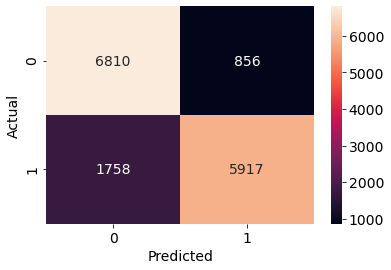

In [67]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='g')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
#plt.savefig('5samples_down_regulated.png')

plt.show()

- The result is telling us that we have 6810+5917 correct predictions
- 1758+856 incorrect predictions.

## Compute precision, recall, F-measure and support


- The **precision** is defined as tp / (tp + fp), where tp is the number of true positives and fp is the number of false positives. It represents the classifier's ability to avoid labeling negative samples as positive

- The **recall** is calculated as tp / (tp + fn), where tp is the number of true positives and fn is the number of false negatives. It measures the classifier's ability to identify all positive samples

- The **F-beta score** is a weighted harmonic mean of precision and recall, with the optimal value at 1 and the worst score at 0. The F-beta score assigns more weight to recall than precision, with the weight determined by the beta factor. A beta value of 1.0 indicates that recall and precision have equal importance

- Finally, the support corresponds to the number of instances of each class in y_test.

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      7666
           1       0.87      0.77      0.82      7675

    accuracy                           0.83     15341
   macro avg       0.83      0.83      0.83     15341
weighted avg       0.83      0.83      0.83     15341



### Interpretation:
Out of the complete set of test data, 83% of the term deposits that were promoted corresponded to the deposits that were preferred by the customers

## ROC curve

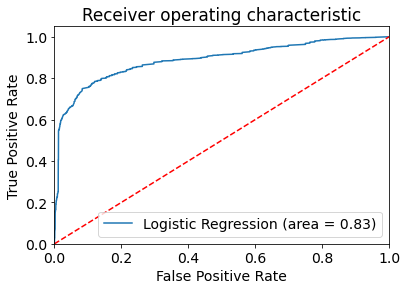

In [74]:

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC_5samples_down_regulated_with_features.png')
plt.show()

- The ROC (Receiver Operating Characteristic) curve is a widely used tool for evaluating binary classifiers
- It is plotted on a graph where the dotted line represents the ROC curve of a completely random classifier 
- A reliable classifier should aim to stay as distant as possible from this line, preferably towards the top-left corner of the graph

## Conclusions

Prior to applying the data to the LR model, several steps were taken,
- Including data visualization to identify the most effective predictors and the least effective predictors
- The imbalance in the y variable was resolved using the SMOTE method
- Recursive feature elimination was also conducted to select the best features that would improve the accuracy of the model
- Additionally, columns with insignificant P-values (>=0.5) were removed after the implementation of the LR method